In [137]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d as spi2d
%matplotlib inline


import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi

Running on  Thu May 11 10:51:04 2017


In [185]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_Coincidence"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]
save = functools.partial(save_to_folder, outputfolder)

In [7]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/"

pattern = "$IC_DATA/3904/dst_*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", ifiles)

# files: ['/home/brais/Documents/Next/Na/data//3904/dst_3904.root.h5']


In [8]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)

In [9]:
data_read = load_dst(ifiles[0], "DST", "Events")

In [10]:
from copy import deepcopy
from functools import reduce

def Filter(data, verbosity=False):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 2500.
    max_S2e = 10000.
    
    if verbosity: print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    if verbosity: print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    if verbosity: print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    if verbosity: print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    if verbosity: print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [11]:
filt_XR, filt_noXR = Filter(data_read,1)
full = data_read[:]

def get_zcorr(zfun, coef):
    def zcorr(z):
        return zfun(coef)/zfun(z)
    return zcorr

Inicial:  50165 50165
nS2 > 1:  4224
S2 XR Energy:  1580
Nsimp > 0:  1580
no XR:  48584


FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f9d9e808268>, values=array([ 8518.45488936,  -733.67958641]), errors=array([ 71.79984014,  31.55348215]), chi2=1.0916258979450295)


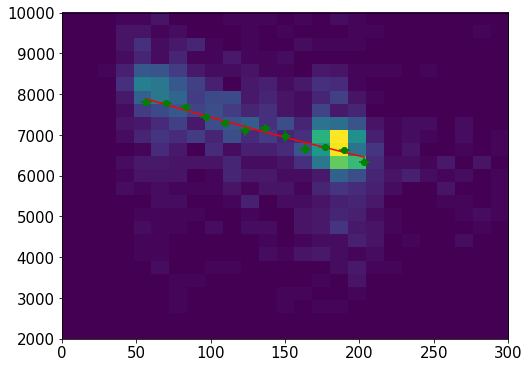

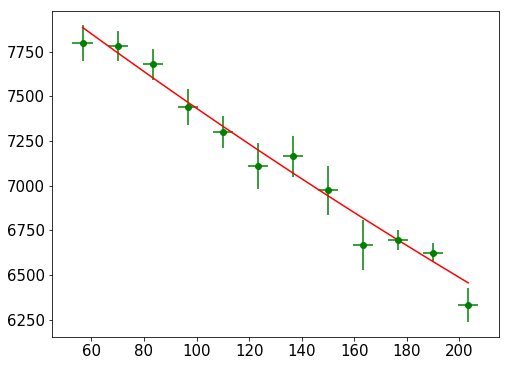

In [17]:
rcut = 305.0
data_ = filt_XR
data_ = data_[data_.R<rcut]

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 12, xrange=[50,210], yrange=[4000,10000])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 155, 180)
#x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

f_g      = lambda z: fitf.expo(z,f.values[0], -730)

zcorr  = get_zcorr(f.fn, np.min(x))
zcorr_g  = get_zcorr(f_g, np.min(x))
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


FitFunction(fn=<function fit.<locals>.<lambda> at 0x7f9d9e6fa9d8>, values=array([  7677.74704782, -12141.57530215]), errors=array([   462.59594103,  49279.51695568]), chi2=7.8284984268962434)


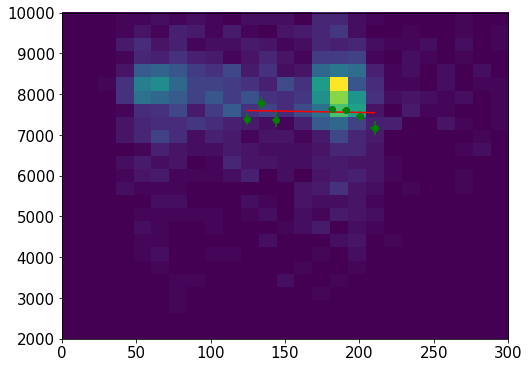

In [18]:
rcut = 180.0
data_ = filt_XR
E = data_.S2e * zcorr(data_.Z)

xbin, ybin, z, axis = hist2d(data_.Z, E, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, E, 10, xrange=[120,215], yrange=[4000,9000])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 150, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)



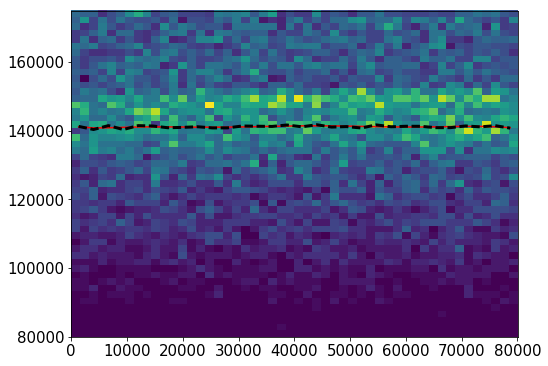

In [63]:
def get_tcorr(tfun, tmin):
    def tcorr(t):
        return tfun(tmin)/tfun(t)
    return tcorr



data_        = full[(full.nS2==1)&(full.R<180)]
E            = data_.S2e * zcorr(data_.Z) #* xycorr(data_.X.values, data_.Y.values)
time         = data_.time.values
time        -= np.min(time)

hist2d(time, E,[50,50],[[min(time),max(time)],[0.8e5,1.75e5]]);

x, y, _      = fitf.profileX(time,E, 30, xrange = (min(time),max(time)), yrange=[1.3e5,1.5e5])
f            = fitf.fit(fitf.polynom, x, y, (6000,-200,1,2,3,1,2,3,5))

plt.plot(x, f.fn(x), fitOpt)
#print(f.values,f.errors)

plt.plot(x, y, profOpt, linewidth=3)
#labels("time (s)", "Energy (pes)")

tcorr = get_tcorr(f.fn, np.min(x))

[  8.00000000e+04   7.82028515e+03   1.00000000e+03   4.20697132e+04
   8.07246346e+03   3.39658593e+02   1.32647320e-25] 
 [  3.94608042e+05   1.63040344e+02   2.36807836e+03   1.83798573e+04
   5.72334604e+01   5.76236543e+01   9.50594456e+01]
res 0.301139914444 0.0332688669936


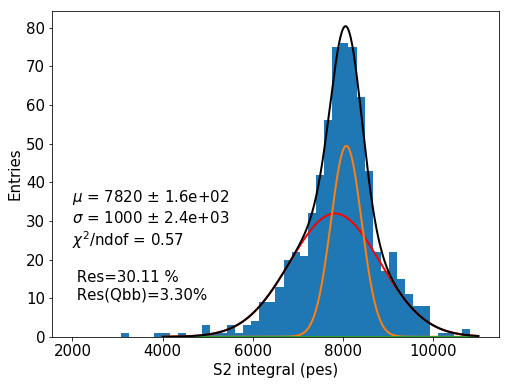

In [20]:
data_ = filt_XR
selZ  = fitf.in_range(data_.Z, 0, 150)
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selZ&selR]

time         = data_.time.values
time        -= np.min(time)

Ez_ = data_.S2e * zcorr(data_.Z) * tcorr(time)


entries, xbins, _ = hist(Ez_, 50, range=(2e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                                  bounds=([ 8e4, 6000, 100, 1e3, 7000, 10, 0],
                                                          [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 10, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
#save("RX XYZ Corr (Z<150 R<180)")


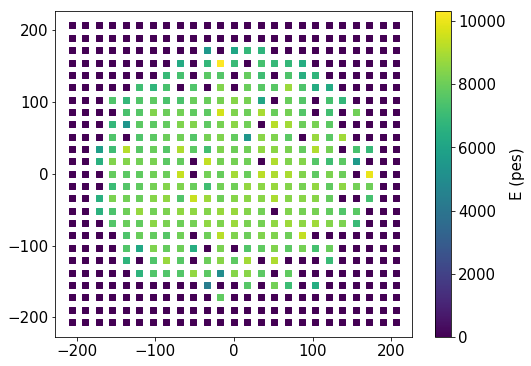

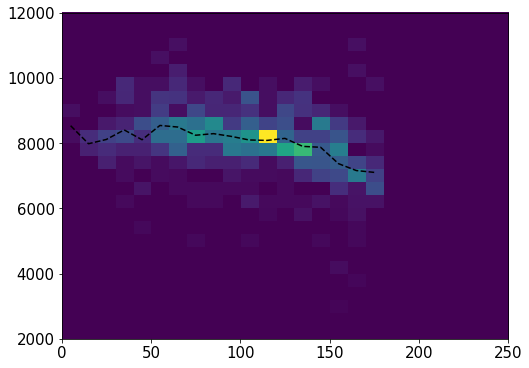

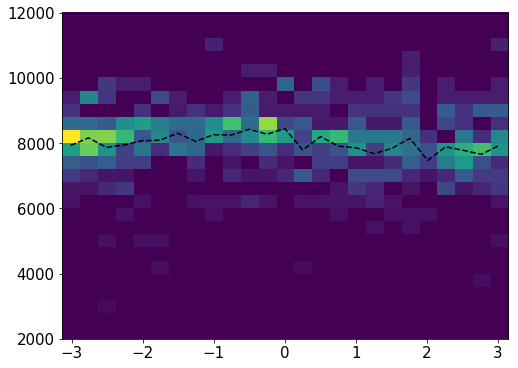

In [69]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 12e3
nbin = 25

data_ = filt_XR
selZ  = fitf.in_range(data_.Z, 0, 150)
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selZ&selR]

time         = data_.time.values
time        -= np.min(time)

Ez_ = data_.S2e * zcorr(data_.Z) * tcorr(time)



pf, _, cb = profile_and_scatter(data_.X, data_.Y, Ez_, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
#labels("x (mm)", "y (mm)")
#save("EvsXY")
"""_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
#save("EvsRPhi")
"""

hist2d(data_.R, Ez_, (nbin, nbin), range=(rrange, Erange), weights=Ez_)
x, y, _ = fitf.profileX(data_.R, Ez_, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("r (mm)", "S2 energy (pes)")
#save("EvsR")

hist2d(data_.Phi, Ez_, (nbin, nbin), range=(prange, Erange), weights=Ez_)
x, y, _ = fitf.profileX(data_.Phi, Ez_, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
#labels("phi (rad)", "S2 energy (pes)")
#save("EvsPhi")

np.savetxt('xycorr_xs_3904.dat',np.array(pf[0]))
np.savetxt('xycorr_ys_3904.dat',np.array(pf[1]))
np.savetxt('xycorr_es_3904.dat',np.array(pf[2]))



In [158]:
def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
#    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr

xs = np.loadtxt('xycorr_xs_3614.dat')
ys = np.loadtxt('xycorr_ys_3614.dat')

es3614  = np.loadtxt('xycorr_es_3614.dat')

es37xx  = np.loadtxt('xycorr_es_S1.dat')
#es3614 *= es37xx[12,12]/ es3614[12,12] 

es3904  = np.loadtxt('xycorr_es_3904.dat')

xycorr_c3 = get_xycorr(xs, ys,es3614+es37xx+es3904)

In [201]:
z = es3904 #es3614+es37xx+
z = np.ones_like(z)*z[z.shape[0]//2, z.shape[1]//2]/z
z[np.where(z==np.inf)] = 1.
xsm, ysm  = np.meshgrid(xs,ys)
xycorr_ip = spi2d(xsm, ysm, z, kind='cubic')

/home/brais/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


[  6.17783650e+04   8.29941486e+03   2.42716993e+02   1.57476963e+04
   9.23878359e+03   3.31408179e+02   3.33008938e+00] 
 [  2.72115635e+03   1.05709675e+01   1.06312042e+01   3.35728827e+03
   6.46923713e+01   7.33033129e+01   1.26930108e+00]
res 0.0688721468122 0.00760874989319


/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


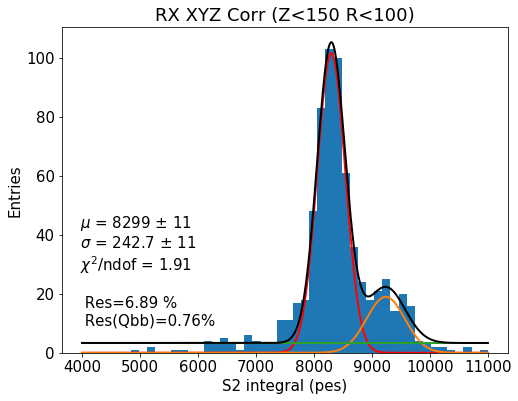

In [196]:
data_ = filt_XR
selZ  = fitf.in_range(data_.Z, 0, 150)
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selZ&selR]

time         = data_.time.values
time        -= np.min(time)

Ez_ = data_.S2e * zcorr(data_.Z) * tcorr(time) *xycorr_c3(data_.X.values, data_.Y.values) #np.diag(xycorr_ip(data_.X.values, data_.Y.values))

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 7.05e3, 11e3)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 100e4, 8000,   500, 15e4,   8550, 300,   10),
                                                  bounds=([  2e3, 6000,    10, 1e3,   8500,  10,   0],
                                                          [ 10e6, 8500, 10000,15e5, 100000, 500, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 10, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
plt.title("RX XYZ Corr (Z<150 R<100)")


[  7.60806464e+04   8.50000000e+03   1.61937272e+03   2.68234996e+04
   8.59900244e+03   5.00000000e+02   2.86704705e-08] 
 [  4.54122547e+05   4.75088945e+02   6.21493822e+03   4.92911347e+04
   8.79625993e+01   3.08001553e+02   6.61839583e+01]
res 0.448661501794 0.049566527426


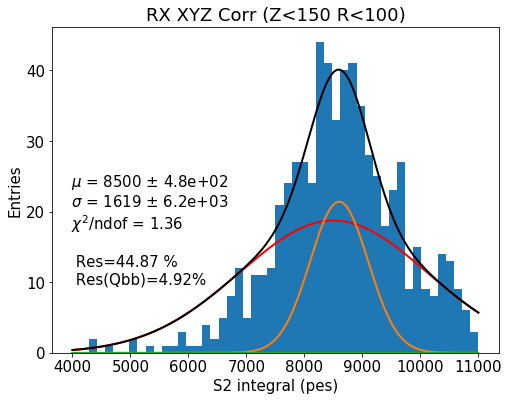

In [202]:
data_ = filt_XR
selZ  = fitf.in_range(data_.Z, 0, 150)
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selZ&selR]

time         = data_.time.values
time        -= np.min(time)

Ez_ = data_.S2e * zcorr(data_.Z) * tcorr(time) * np.diag(xycorr_ip(data_.X.values, data_.Y.values))

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 7.05e3, 11e3)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 100e4, 8000,   500, 15e4,   8550, 300,   10),
                                                  bounds=([  2e3, 6000,    10, 1e3,   8500,  10,   0],
                                                          [ 10e6, 8500, 10000,15e5, 100000, 500, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 10, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
plt.title("RX XYZ Corr (Z<150 R<100)")


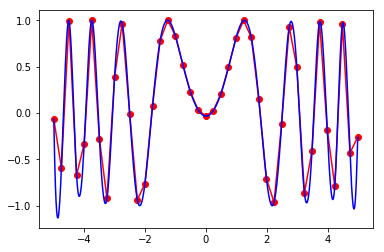

In [177]:
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = spi2d(x, y, z, kind='cubic')
xnew = np.arange(-5.01, 5.01, 1e-3)
ynew = np.arange(-5.01, 5.01, 1e-3)
znew = f(xnew, ynew)
plt.plot(x, z[:, 0], 'ro-', xnew, znew[:, 0], 'b-')
plt.show()

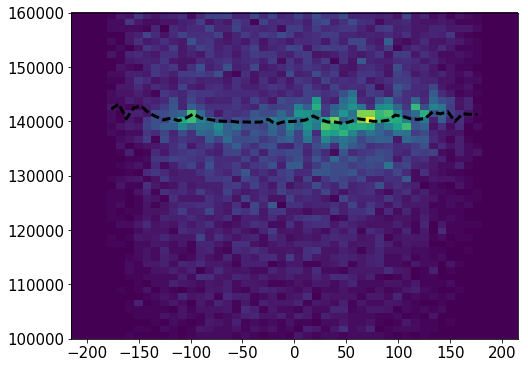

In [102]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selR]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr_g(data_.Z) *tcorr(time) * xycorr_c(data_.X.values,data_.Y.values)
hist2d(data_.X,E,[50,50],[[-215,215],[1.0e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.X,E, 50, xrange=[-180, 180], yrange=[1.32e5,1.5e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
xcorr_PP = get_xcorr(x, y)

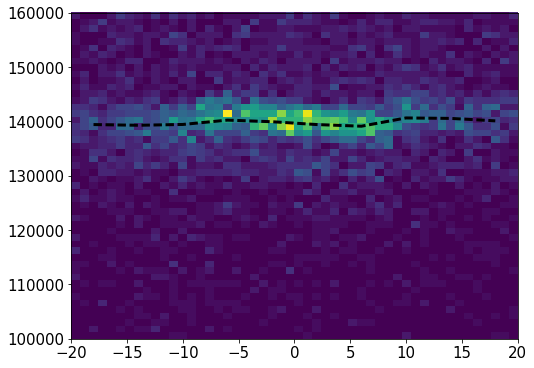

In [106]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selR]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr_g(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values)
hist2d(data_.Y,E,[50,50],[[-20,20],[1.0e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.Y,E, 10, xrange=[-20, 20], yrange=[1.3e5,1.5e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
ycorr_PP = get_xcorr(x, y)

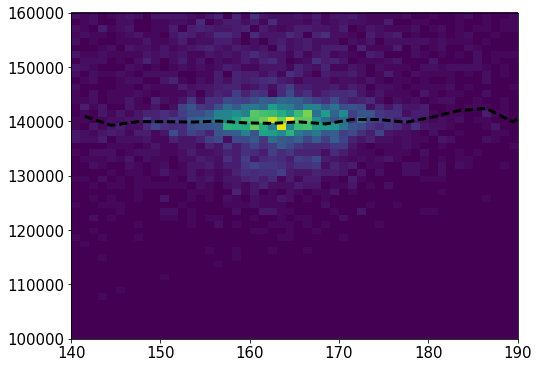

In [107]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R,   0, 180)
selZ  = fitf.in_range(data_.Z, 140, 200)
data_ = data_[selR&selZ]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr_g(data_.Z) *tcorr(time) * xycorr_c(data_.X.values,data_.Y.values)

hist2d(data_.Z,E,[50,50],[[140,190],[1.0e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.Z,E, 20, xrange=[140, 200], yrange=[1.3e5,1.5e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
zcorr_PP = get_xcorr(x, y)

[  3.91041880e+06   1.39749321e+05   2.34966987e+03   5.07064270e+01]
res 0.03959570267 0.0180537558592


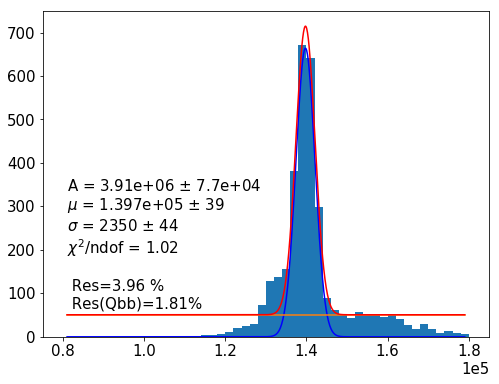

In [110]:
data_ = full[(full.nS2 ==1)&(full.S1e<150)]
selR  = fitf.in_range(data_.R,   0, 100)
selZ  = fitf.in_range(data_.Z, 140, 200)
data_ = data_[selR&selZ]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.35e5, 1.6e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.2e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

[  4.57302600e+06   1.47526717e+05   2.34740153e+03   1.09258120e+02]
res 0.0374720642139 0.0170854777979


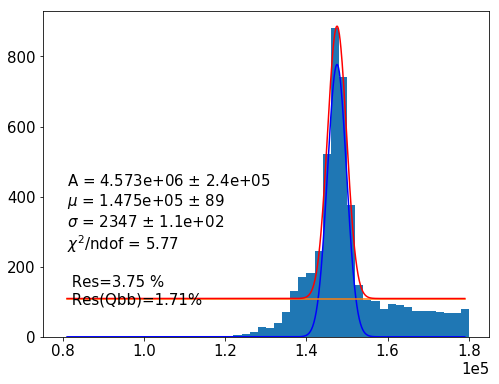

In [111]:
data_ = full[(full.nS2 ==1)&(full.S2w <20)]
selR  = fitf.in_range(data_.R,   0, 180)
selZ  = fitf.in_range(data_.Z, 140, 200)
data_ = data_[selR&selZ]


time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values)
E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.X.values) * zcorr_PP(data_.Z.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.4e5, 1.6e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.5e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.4e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

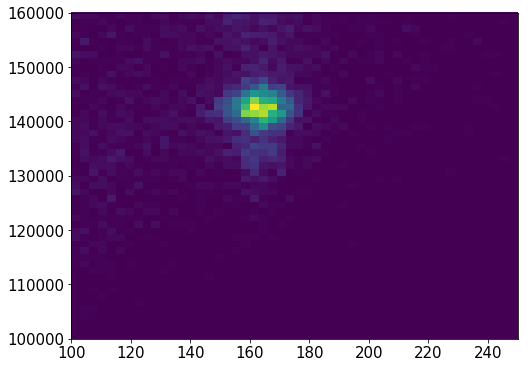

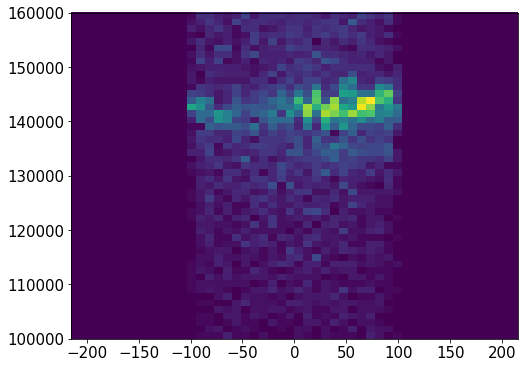

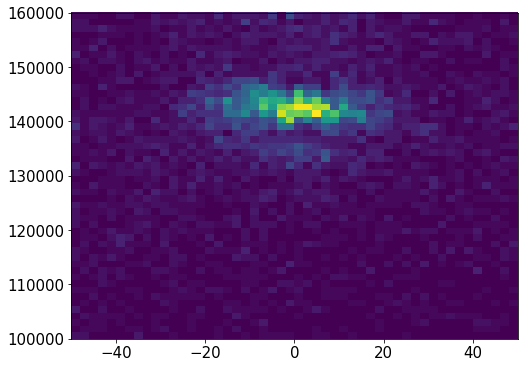

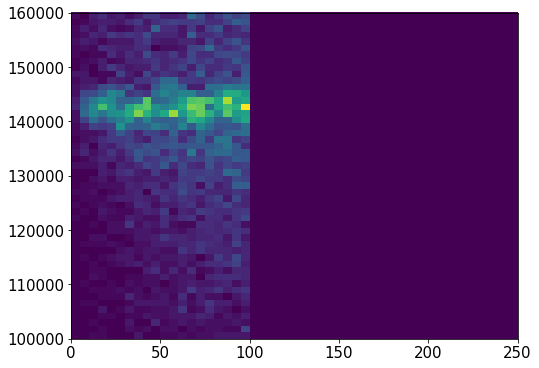

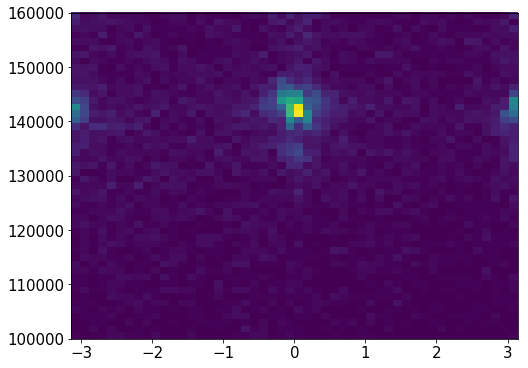

In [51]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 100)
data_ = data_[selR]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) *xcorr_PP(data_.X.values)*ycorr_PP(data_.Y.values)

hist2d(data_.Z,E,[50,50],[[100,250],[1.0e5, 1.6e5]]);
hist2d(data_.X,E,[50,50],[[-215,215],[1.0e5, 1.6e5]]);
hist2d(data_.Y,E,[50,50],[[-50,50],[1.0e5, 1.6e5]]);
hist2d(data_.R,E,[50,50],[[0,250],[1.0e5, 1.6e5]]);
hist2d(data_.Phi,E,[50,50],[[-pi,pi],[1.0e5, 1.6e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [29]:
print(len(full[full.nS2 ==1]))

45941


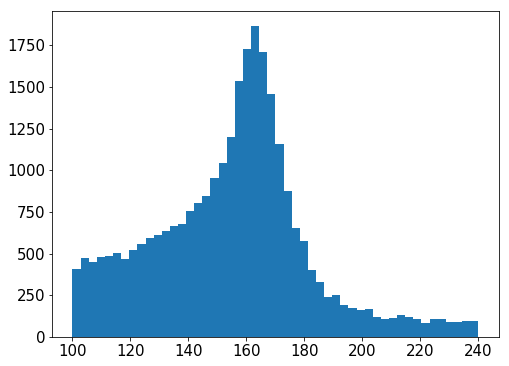

In [52]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selR]

hist(data_.Z,50,[100,240]);

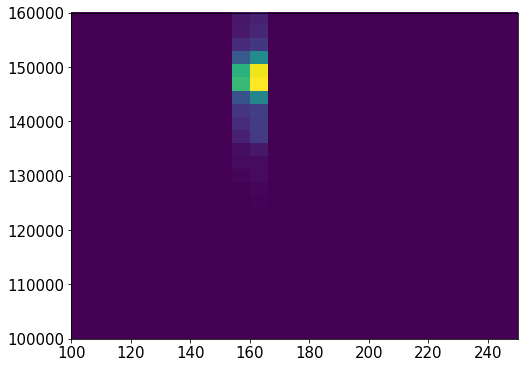

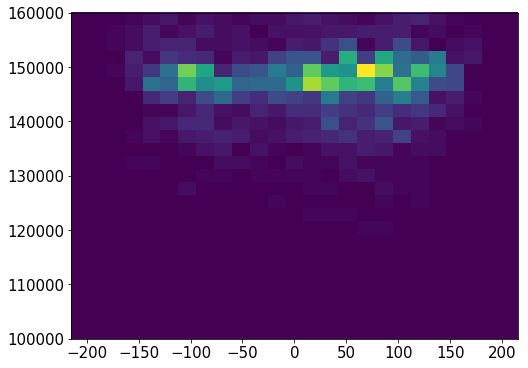

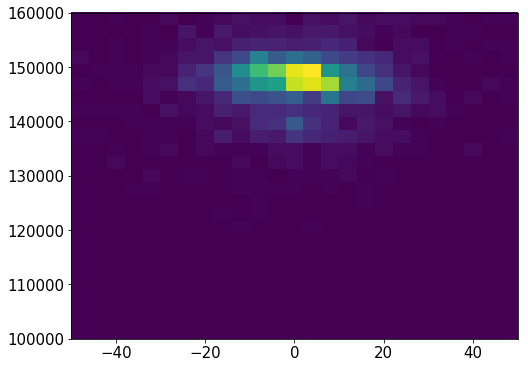

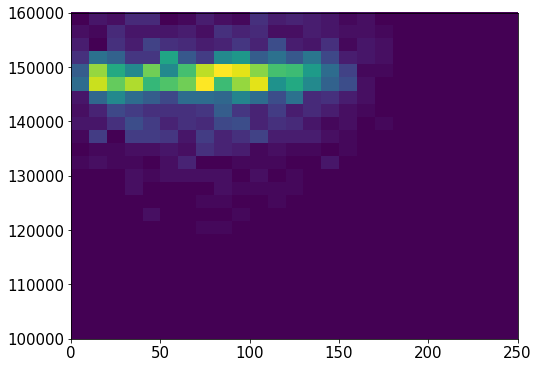

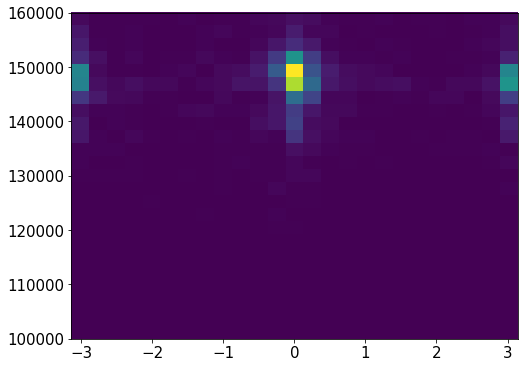

In [54]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
selZ  = fitf.in_range(data_.Z,155,165)
data_ = data_[selR&selZ]



time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) 
E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values) * zcorr_PP(data_.Z.values)
nbin = 25
hist2d(data_.Z,E,[nbin,nbin],[[100,250],[1.0e5, 1.6e5]]);
hist2d(data_.X,E,[nbin,nbin],[[-215,215],[1.0e5, 1.6e5]]);
hist2d(data_.Y,E,[nbin,nbin],[[-50,50],[1.0e5, 1.6e5]]);
hist2d(data_.R,E,[nbin,nbin],[[0,250],[1.0e5, 1.6e5]]);
hist2d(data_.Phi,E,[nbin,nbin],[[-pi,pi],[1.0e5, 1.6e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

[  1.44267776e+06   1.47691022e+05   2.42122672e+03   1.00000000e+01]
res 0.0386075528103 0.0176032065542


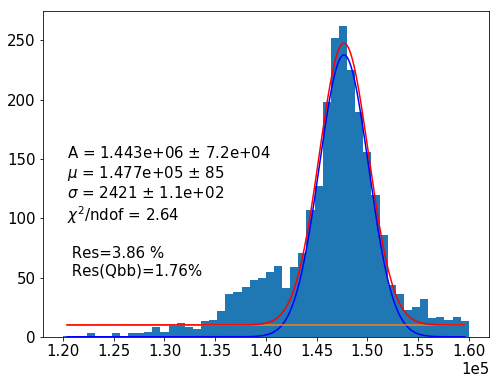

In [57]:
data_ = full[(full.nS2 ==1)&(full.S2w <20)]
selR  = fitf.in_range(data_.R, 0, 100)
selZ  = fitf.in_range(data_.Z,140,190)
data_ = data_[selR&selZ]



time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) 
E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values) * zcorr_PP(data_.Z.values)

entries, xbins, _ = hist(E, 50, range=(1.2e5, 1.6e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.44e5, 1.6e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.2e5, 5000, 0.001),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 10] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

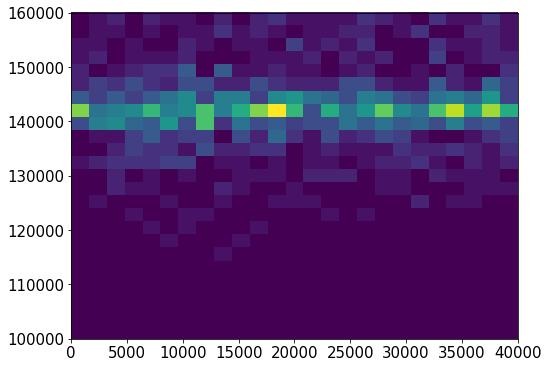

In [59]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
selZ  = fitf.in_range(data_.Z,155,165)
data_ = data_[selR&selZ]



time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) *xcorr_PP(data_.X.values)*ycorr_PP(data_.Y.values)
nbin = 25
hist2d(time,E,[nbin,nbin],[[0,0.4e5],[1.0e5, 1.6e5]]);


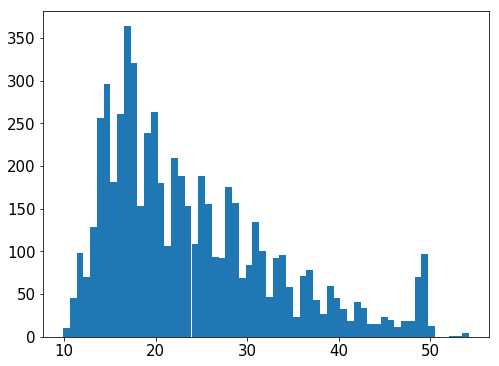

In [60]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
selZ  = fitf.in_range(data_.Z,155,165)
data_ = data_[selR&selZ]

hist(data_.S2w,60);